# Reconstructing halo parameters from images with SWYFT

In [249]:
import torch
from tqdm import tqdm
import pylab as plt
import numpy as np
import torchinterp1d
import swyft
interp1d = torchinterp1d.Interp1d()

In [250]:
NPIX = 25

In [251]:
def profile(R, M, gamma = 1.0):
    r = torch.logspace(-4, 2, 100).cuda()  # radial grid
    R = R.unsqueeze(-1)
    M = M.unsqueeze(-1)
    return r, M*R*R/(r + R)**(3-gamma)/(r+0.01)**gamma

In [252]:
grid = torch.linspace(-2, 2, NPIX).cuda()
X, Y = torch.meshgrid([grid, grid])

In [253]:
def generate(x, R, M, gamma = 1.0):
    N = len(x)
    dist0 = (X.unsqueeze(-1)-x[:,0]).T
    dist1 = (Y.unsqueeze(-1)-x[:,1]).T
    r, tab = profile(R, M, gamma = gamma)  # generate tabulated profiles
    RR = (dist0**2 + dist1**2)**0.5
    RR = RR.reshape(N, NPIX*NPIX)
    res = torch.exp(interp1d(r, torch.log(tab), RR)).sum(axis=0)
    img = res.reshape(NPIX, NPIX)
    img = img.cpu().numpy()
    img  = np.random.poisson(img*30+10)
    return img

In [254]:
for i in tqdm(range(20)):
    x = torch.randn(N, 2).cuda()  # random positions
    R = torch.rand(N).cuda()*0.3 + 0.1 # random size
    M = torch.rand(N).cuda() # random mass
    img = generate(x, R, M, gamma = 1.0)

100%|██████████| 20/20 [00:00<00:00, 237.02it/s]


In [255]:
# x ~ p(x|z)
def model(z):
    gamma = 0.5 + z[0]
    N = 100 + int(900*z[1])
    x = torch.randn(N, 2).cuda()  # random positions
    R = torch.rand(N).cuda()*0.3 + 0.1 # random size
    M = torch.rand(N).cuda() # random mass
    img = generate(x, R, M, gamma = gamma)
    return img

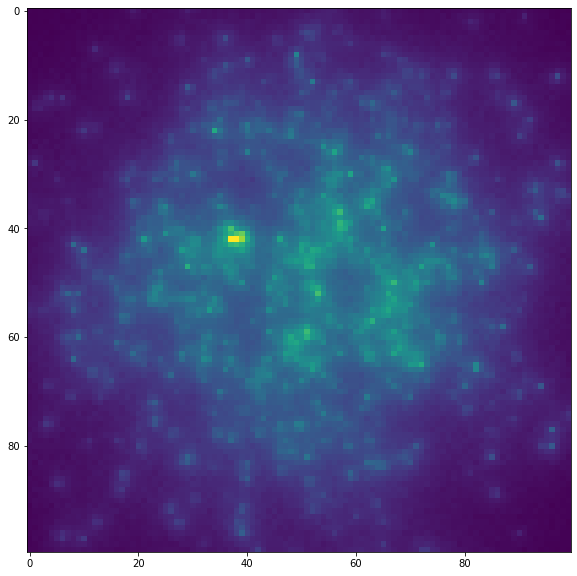

In [256]:
plt.figure(figsize = (10, 10))
z0 = np.array([0.2, 0.8])
img = model(z0)
plt.imshow(img)

In [257]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters

In [258]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0a = torch.nn.Conv2d(1, 100, 1)
        self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv0a(x)
        x = torch.relu(x)
        x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [259]:
# Instantiate network

sw = swyft.SWYFT(img, model, zdim = 2, device = DEVICE, head = Head)
sw.run(nworkers=0, nrounds = 1, max_epochs = 20, early_stopping_patience = 3, nsamples = 3000, nbatch = 16, recycle_net = False, threshold = 1e-6)

Adding samples.: 100%|██████████| 2997/2997 [00:00<00:00, 33247.54it/s]


Adding 2997 new samples.


Adding simulations: 100%|██████████| 2997/2997 [00:00<00:00, 8990.82it/s]


Number of output features: 3240
Start training
LR iteration 0
Total epochs: 15
Validation losses: [5.093445464968681, 3.774776875972748, 2.5322532542049885, 2.9047073423862457, 2.4500636644661427, 2.617249894887209, 2.2861359529197216, 4.131170392036438, 2.3486912436783314, 2.058531314134598, 2.0867063216865063, 2.038139719516039, 2.6137548983097076, 2.2015410773456097, 2.376992419362068]
LR iteration 1
Total epochs: 5
Validation losses: [1.7307105753570795, 1.6673481622710824, 1.6985628586262465, 1.7560009006410837, 1.8762701638042927]
LR iteration 2
Total epochs: 5
Validation losses: [1.629014516249299, 1.6281036669388413, 1.6293174512684345, 1.6315642166882753, 1.631739653646946]


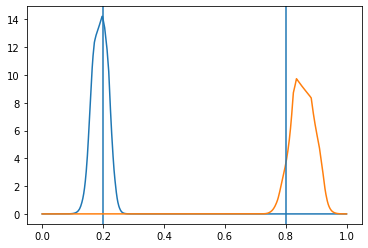

In [203]:
z0 = np.array([0.2, 0.8])
img = model(z0)
for i in range(2):
    z, p = sw.posterior(i, x0 = img)
    plt.plot(z, p)
    plt.axvline(z0[i])